# Context

This dataset contains an airline passenger satisfaction survey. What factors are highly correlated to a satisfied (or dissatisfied) passenger? Can you predict passenger satisfaction?

In [ ]:
! pip install pandas-profiling==3.1.0

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
set_config(display="diagram")

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

We will use the existing index in the original datasets when importing the data.

The original datasets contain both the train and test sets, and the target (Satisfaction) was listed in the last column. We will use the train set for
training, and the test set for evaluating the model performance.

After dropping the target column, we will use the remaining columns as features
(23 in total).

In [ ]:
X_train = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv', index_col=0)
X_train, y_train = X_train.drop('satisfaction', axis=1), X_train.satisfaction.tolist()
X_test, y_test = test_df.drop('satisfaction', axis=1), test_df.satisfaction.tolist()
X_train.head(2)

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,5,4,3,4,4,5,5,25,18.0
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,1,5,3,1,4,1,1,6.0


Since the target contains two labels, we use `LabelEncoder()` to convert
categorical variables to numerical in both train and test sets.

In [ ]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
print(f'There are only two classes:')
print(le.classes_)

There are only two classes:
['neutral or dissatisfied' 'satisfied']


In [ ]:
print(f'Shape of X_train: {X_train.shape}')
print(f'There are {X_train.shape[0]} rows and {X_train.shape[1]} columns.')

Shape of X_train: (103904, 23)
There are 103904 rows and 23 columns.


# EDA
## Unnecessary columns
We see that there are 23 features and 1 target variable, and there are 103,904
data points. However, not all features are useful. The first first feature "id" is not helpful in prediction because there are too many unique values.

Since unique IDs do not provide any significant information, we can safely drop
them.

In [ ]:
# Number of unique ID.
print(f'Number of unique ID: {len(X_train.id.unique())}')

Number of unique ID: 103904


In [ ]:
# Drop the ID column.
X_train, X_test = X_train.drop('id', axis=1), X_test.drop('id', axis=1)

## Class distribution
The two classes of target variable differ by over 10,000 data points. It is a small difference relative to the entire datasets, we will nevertheless use `class_weights` = "balanced" in our Logistic Regression Model later in the pipeline for better performance.

Otherwise, given the relatively small class imbalance, we will treat it as a balanced datasets when implementing other models.

Text(0, 0.5, 'Count')

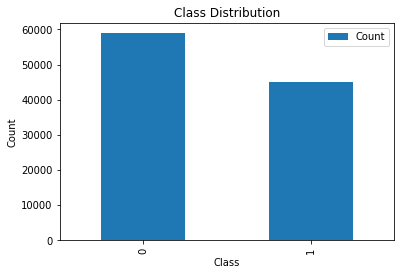

In [ ]:
class_counter = Counter(y_train)
pd.DataFrame(class_counter.most_common(), columns=['Class', 'Count']).set_index('Class').plot.bar()
plt.title('Class Distribution')
plt.ylabel('Count')

## Missing values
Since only the variable "Arrival Delay in Minutes" has missing data, and since
the number of missing data is small compared to the data size (310 out of
103,904), we will impute the missing data later in the pipeline.

In [ ]:
print(f'Missing values:')
print(f'-' * 50)
print(X_train.isnull().sum(axis=0))
print()

Missing values:
--------------------------------------------------
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
dtype: int64



## Data types

As we see here, ("Gender", "Customer Type", "Type of Travel") are definitely categorical values while ("Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes") can be seen as numerical. 

Others, however, can be either treated as categorical or ordinal such as the "Class" feature which contains ("Eco Plus", "Business", "Eco"]. We will experiment with both.



In [ ]:
X_train.info()
X_train["Class"].unique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103904 entries, 0 to 103903
Data columns (total 22 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  object 
 1   Customer Type                      103904 non-null  object 
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  object 
 4   Class                              103904 non-null  object 
 5   Flight Distance                    103904 non-null  int64  
 6   Inflight wifi service              103904 non-null  int64  
 7   Departure/Arrival time convenient  103904 non-null  int64  
 8   Ease of Online booking             103904 non-null  int64  
 9   Gate location                      103904 non-null  int64  
 10  Food and drink                     103904 non-null  int64  
 11  Online boarding                    1039

array(['Eco Plus', 'Business', 'Eco'], dtype=object)

## Generate Training Set EDA Report

We generated an EDA report and we will compare the differences between the original dataset and samples wrongly predicted by the model later in the section of error analysis, with the help of python package `Pandas Profiling`. Here is a glance of the overview.

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(X_train, title="Training Set EDA Report",minimal=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Preprocessing and Machine Learning
## Logistic Regression

**Ordinal or categorical features** As mentioned before, some values can either been treated as categorical or ordinal values such as "Class". We will experiment with both, beggining with treating them as categorical.**As we will see, model performance will be significantly better when treating them as categorical.**

**Standardization** We have two different types of standardization methods available: StandardScaler(feature-wise) and Normalizer(sample-wise). According to our reference and ML common practice, `when features have different units, e.g. (ℎ𝑒𝑖𝑔ℎ𝑡,𝑎𝑔𝑒,𝑖𝑛𝑐𝑜𝑚𝑒), Normalizer is not used as a pre-processing step`. Therefore, we will use `StandardScaler`.

Refs:
- https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#:~:text=pclass%3A%20ordinal%20integers%20%7B1%2C%202%2C%203%7D.
- https://www.researchgate.net/post/Is-the-likert-scale-ordinal-nominal-discrete-or-continuous-ratio-Is-it-valid-to-use-one-of-them-as-an-approach-of-another#:~:text=The%20likert%20scale%20is%20originally,managed%20on%20a%20numerical%20scale.
- https://datascience.stackexchange.com/questions/45900/when-to-use-standard-scaler-and-when-normalizer

### Logistic Regression with numerical and categorical values only

In [ ]:
# Numerical variables.
num_vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
print(f'Numerical variables: {num_vars}')

# Remaining variables are categorical variables.
cat_vars = [x for x in X_train.columns if x not in num_vars and x != 'id']
print(f'Categorical variables: {cat_vars}')

# Record model performance for comparison.
models_performance = []

Numerical variables: ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Categorical variables: ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']


In [ ]:
# Preprocessing: 1. Impute missing values with mean. 2. Standardize. 3. One-hot
# encode.
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_vars),
        ("cat", categorical_transformer, cat_vars),
    ]
)

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression(random_state=42, 
                                             class_weight='balanced',
                                             solver='saga'))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'Logistic Regression score: {test_score:.3f}')

models_performance.append(["Logistic Regression", test_score])
clf

Logistic Regression score: 0.933


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Flight Distance',
                                                   'Departure Delay in Minutes',
                                                   'Arrival Delay in Minutes']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender', 'Customer Type',
                                                   'Type of Travel', 'Class',
                                                   'Inflight wifi service',
                                                   'Departure/Arrival time '
                                                   'convenient',
                                                   'Ease of Online booking',
                                                   'Gate location',
                                                   'Food and drink',
                                                   'Online boarding',
                                                   'Seat comfort',
                                                   'Inflight entertainment',
                                                   'On-board service',
                                                   'Leg room service',
                                                   'Baggage handling',
                                                   'Checkin service',
                                                   'Inflight service',
                                                   'Cleanliness'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='saga'))])

Logistic Regresion Hyperparameters Tuning

In [ ]:
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__C": [0.1, 1.0, 10, 100],
    "classifier__class_weight": ["balanced", None],
    "classifier__penalty": ["l1", "l2", 'none'],
}

grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)
print(f"Internal CV score: {grid_search.best_score_:.3f}")
print(
    (
        "Best model performance: %.3f"
        % grid_search.score(X_test, y_test)
    )
)

Best params:
{'classifier__C': 0.1, 'classifier__class_weight': None, 'classifier__penalty': 'l1', 'preprocessor__num__imputer__strategy': 'mean'}
Internal CV score: 0.934
Best model performance: 0.932


### Logistic Regression with numerical, categorical, and ordinal values

As we will show below, the performance of such treatment is significantly inferior than treating them as categorical features.

In [ ]:
# Categorical variables.
cat_vars = ['Gender', 'Customer Type', 'Type of Travel']
print(f'Categorical variables: {cat_vars}')

# Numerical variables.
num_vars = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
print(f'Numerical variables: {num_vars}')
print(f'There are {len(cat_vars)} categorical variables and {len(num_vars)} numerical variables.')

# Remaining variables are ordinal variables. 
ordinal_vars = [x for x in X_train.columns if x not in cat_vars and x not in num_vars and x != 'id']
print(f'-' * 50)
print(f'There are {len(ordinal_vars)} ordinal variables.')
print(f'Note that `id` is not included in the ordinal variables.')
print()
print(f'Ordinal variables:')
for var in ordinal_vars:
    print(f'{var}')

Categorical variables: ['Gender', 'Customer Type', 'Type of Travel']
Numerical variables: ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
There are 3 categorical variables and 4 numerical variables.
--------------------------------------------------
There are 15 ordinal variables.
Note that `id` is not included in the ordinal variables.

Ordinal variables:
Class
Inflight wifi service
Departure/Arrival time convenient
Ease of Online booking
Gate location
Food and drink
Online boarding
Seat comfort
Inflight entertainment
On-board service
Leg room service
Baggage handling
Checkin service
Inflight service
Cleanliness


NB: Be cautious that, not every survey question is answered. In other words, some questions are not rated. Following common practice of survey data analysis,
we should have dropped samples with any unanswered questions. However, it's likely that future passengers will have the similar issues. So we keep those samples for now.

In [ ]:
# How many rows contain 0 (not rated) in any of the ordinal variables?
for var in ordinal_vars:
    print(f'{var}: {X_train[X_train[var] == 0].shape[0]}')

Class: 0
Inflight wifi service: 3103
Departure/Arrival time convenient: 5300
Ease of Online booking: 4487
Gate location: 1
Food and drink: 107
Online boarding: 2428
Seat comfort: 1
Inflight entertainment: 14
On-board service: 3
Leg room service: 472
Baggage handling: 0
Checkin service: 1
Inflight service: 3
Cleanliness: 12


Therefore, we will deal with only numerical and categorical values, and the model produces a pretty good performance.

In [ ]:
print(f'Logistic Regression with numerical and categorical values: {clf.score(X_train, y_train)}')

Logistic Regression with numerical and categorical values: 0.9328322297505389


## Use other classification models to further improve performance

As our experiments so far suggest, we will continue to treat our features as
either numerical or categorical.

In the following cells, we will use other classification models to see how performance can be improved on this particular dataset.

### Decision Tree

In [ ]:
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier

# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("classifier", tree.DecisionTreeClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'Decision Tree: {test_score:.3f}')

Decision Tree: 0.947


Decision Tree Hyperparameter Tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", tree.DecisionTreeClassifier(random_state=42))]
)
param_grid = {
    "classifier__max_depth": [1, 5, 10],
    "classifier__min_samples_split": [1, 5, 10],
    "classifier__min_samples_leaf": [1, 5, 10],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__class_weight": ["balanced", None],
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)
models_performance.append(["Decision Tree", grid_search.score(X_test, y_test)])

### Random Forest

Default hyperparameters

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'Random Forest score: {test_score:.3f}')
models_performance.append(["Random Forest", test_score])

Random Forest score: 0.962


Random Forest Hyperparameter tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier(random_state=42))]
)
param_grid = {
    "classifier__class_weight": ["balanced", None],
    "classifier__bootstrap": [True, False],
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.9629658145980905

### KNN

Default hyperparameters

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", KNeighborsClassifier())]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'KNN score: {test_score:.3f}')
models_performance.append(["KNN", test_score])

KNN score: 0.937


KNN Hyperparameter Tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", KNeighborsClassifier())]
)
param_grid = {
    "classifier__n_neighbors": [5, 10],
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.938789651986449

### Support Vector Machine

Default hyperparameters

In [ ]:
from sklearn.svm import SVC

# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", SVC(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'SVM score: {test_score:.3f}')
models_performance.append(["SVM", test_score])

SVM score: 0.962


Support Vector Machine Hyperparameter tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", SVC(random_state=42))]
)
param_grid = {
    "classifier__C": [1],
}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.9617724052971974

### Support Vector Machine

Default hyperparameters

In [ ]:
from sklearn.svm import SVC

# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", SVC(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'SVM score: {test_score:.3f}')
models_performance.append(["SVM", test_score])

SVM score: 0.962


Support Vector Machine Hyperparameter tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", SVC(random_state=42))]
)
param_grid = {
    "classifier__C": [1],
}
grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.9617724052971974

### Extremely Randomized Trees
Default hyperparameters

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", ExtraTreesClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'Extremely Randomized Trees score: {test_score:.3f}')
models_performance.append(["Extremely Randomized Trees", test_score])

Extremely Randomized Trees score: 0.962


Extremely Randomized Trees Hyperparameter Tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", ExtraTreesClassifier(random_state=42))]
)
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__n_estimators": [10, 50, 100],
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.9618109023714198

### AdaBoost

Default hyperparameters

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", AdaBoostClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'AdaBoost score: {test_score:.3f}')
models_performance.append(["AdaBoost", test_score])

AdaBoost score: 0.927


AdaBoost Hyperparameter Tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", AdaBoostClassifier(random_state=42))]
)
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__n_estimators": [10, 50, 100],
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.9291268863566369

### XGBoost

Default hyperparameters

In [ ]:
# Classifier.
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", xgb.XGBClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'XGBoost score: {test_score:.3f}')
models_performance.append(["XGBoost", test_score])

XGBoost score: 0.942


XGBoost Hyperparameter Tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", xgb.XGBClassifier())]
)
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__n_estimators": [10, 50, 100],
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.9417924237757931

### Gradient Boosting Decision Trees

Default hyperparameters

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Classifier
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", GradientBoostingClassifier(random_state=42))]
)
clf.fit(X_train, y_train)
test_score = clf.score(X_test, y_test)
print(f'Gradient Boosting score: {test_score:.3f}')
models_performance.append(["Gradient Boosting", test_score])

Gradient Boosting score: 0.945


Gradient Boosting Decision Trees Hyperparameter Tuning

In [ ]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", GradientBoostingClassifier(random_state=42))]
)
param_grid = {
    "preprocessor__num__imputer__strategy": ["mean", "median"],
    "classifier__n_estimators": [10, 50, 100],
}
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.score(X_test, y_test)

0.9445257160455806

## Model Performance Comparison and Model Choice

Apparently, among all the models we have tried, Random Forest and other more complex models produce better results than Logistic Regression. 
But as we see here, there are only minor differences between their performance, ranging between a few percentage points. 
In addition, since we are interested in the magnitudes at which features impact the target variable, we will use Logistic Regression which has better interpretibility.

In [ ]:
model_score_df = pd.DataFrame(models_performance, 
                              columns=["Model", "Score"]).sort_values(by="Score", ascending=False)
model_score_df.reset_index(drop=True, inplace=True)
model_score_df

,Model,Score
0,Extremely Randomized Trees,0.962350
1,Random Forest,0.962080
2,SVM,0.961772
3,SVM,0.961772
4,Gradient Boosting,0.944526
5,Decision Tree,0.942254
6,XGBoost,0.941792
7,KNN,0.936749
8,Logistic Regression,0.932977
9,AdaBoost,0.926548


# Model Interpretation, Error Analysis, and Conclusions
As mentioned before, since Logistic Regression has a good performance and is more interpretable, we will use Logistic Regression for model interpretation and error analysis.

Because pipeline is not giving out transformed feature names, we will decompose the pipeline, transform the data step by step, and then train it.

In [ ]:
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore")

X_train_logit = pd.DataFrame()
X_train_logit[num_vars] = imputer.fit_transform(X_train[num_vars])
X_train_logit[num_vars] = scaler.fit_transform(X_train_logit[num_vars])
encoder.fit_transform(X_train[cat_vars])
transformed_names = encoder.get_feature_names(input_features=cat_vars).tolist()
X_train_logit[transformed_names] = encoder.fit_transform(X_train[cat_vars]).toarray()

X_test_logit = pd.DataFrame()
X_test_logit[num_vars] = imputer.transform(X_test[num_vars])
X_test_logit[num_vars] = scaler.transform(X_test_logit[num_vars])
X_test_logit[encoder.get_feature_names(input_features=cat_vars)] = encoder.transform(X_test[cat_vars]).toarray()

In [ ]:
logit = LogisticRegression(random_state=42, 
                                             class_weight='balanced',
                                             solver='saga')
logit.fit(X_train_logit, y_train)
logit.score(X_test_logit, y_test)

0.9329765937788728

## Model Interpretation
Since the coefficients of logistic regression represent the change in log odds of the target variable, we will transform them to give us a sense of the actual impacts of our feature variables.

As we see in the graph which plots the top 10 features, "Inflight wifi service" has a significantly large impact compared to other features, especially when "Inflight wifi service" is equal to 0, suggesting a strong correlation between this feature and the target variable. Going back to the data description page, we see this note "Inflight wifi service: Satisfaction level of the inflight wifi service (0:Not Applicable;1-5)". We are not sure what "Not Applicable" means in this context. It could be "wifi not available", "did not use wifi", or simply left blank. 

Regardless, it seems very counterintuitive that "Inflight wifi service_0" has such a huge impact on "satisfaction". One possible reason could be that those who filled the question with 0 did not take the survey seriously and are likely to pick "satisfied" without looking into it.

Other top features such as "Inflight wifi service_5", "Type of Travel_Business travel" make much more sense.

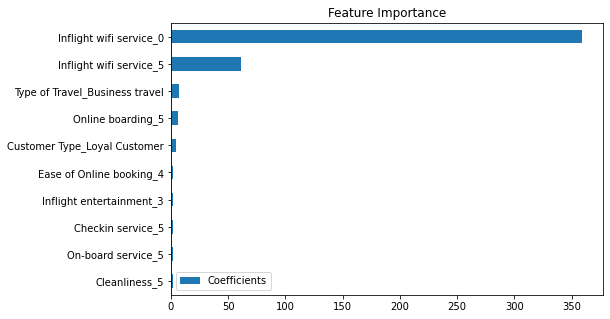

In [ ]:
coefs = np.exp(logit.coef_)
feature_importance = pd.DataFrame(coefs, index=['Coefficients'], columns=logit.feature_names_in_).transpose()
feature_importance=feature_importance.sort_values(by=['Coefficients'])
feature_importance.tail(10).plot(kind='barh', figsize=(10,5))
plt.title('Feature Importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

## Error Analysis
In this section we analyzed in detail how the model performs and where it makes wrong predictions. We included the precision/recall score board, confusion matrix, error samples, and EDA report on error samples.

### Precision/Recall
We can see that both precision and recall look pretty good.

In [ ]:
y_pred = logit.predict(X_test_logit)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     14573
           1       0.92      0.93      0.92     11403

    accuracy                           0.93     25976
   macro avg       0.93      0.93      0.93     25976
weighted avg       0.93      0.93      0.93     25976



### Confusion matrix
The confusion matrix also tells that the number of false positives is roughly equal to the number of false negatives.

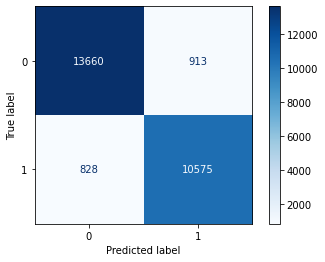

In [ ]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logit, X_test_logit, y_test, cmap="Blues")

### Error Samples
Here is a glance of what samples are given wrong predictions.

In [ ]:
X_error = X_test.copy()
X_error['Predicted'] = y_pred
X_error['Actual'] = y_test
X_error.query('Predicted != Actual', inplace=True)
X_error.sample(5, random_state=42)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,Predicted,Actual
7251,Female,Loyal Customer,18,Business travel,Eco,1747,0,5,5,5,...,4,3,4,2,4,0,86,59.0,1,0
22389,Male,disloyal Customer,23,Business travel,Eco,987,4,4,4,3,...,5,3,1,2,4,3,0,0.0,0,1
14429,Female,disloyal Customer,39,Business travel,Business,308,4,4,4,1,...,5,4,4,5,4,1,52,65.0,1,0
15108,Male,disloyal Customer,23,Business travel,Eco,430,4,3,4,2,...,5,4,3,1,3,3,0,0.0,0,1
10590,Male,disloyal Customer,57,Business travel,Eco,147,4,0,4,1,...,4,5,2,4,5,3,23,45.0,1,0


### EDA Report on Error Samples
Comparing the the error sample report to the original report, we do have some interesting findings.

For example, while 19.1% of the original samples have "Inflight wifi service" equal to 4, the number goes up to 71.3% in the error samples.

Similarly, 18.8% of the original samples have "Ease of online booking" equal to 4, the number goes up to 48% in the error samples.

The same goes for "Online boarding", "Inflight entertainment", "Onboard service", "Legroom Service", and "Baggage handling", which are all ratings ranging from 0 to 5.

It seems that our model has a trouble dealing with those who tend to choose 4 out of 5 for survey questions.

In [ ]:
from pandas_profiling import ProfileReport
X_error_profile = ProfileReport(X_error, title="Error Sample EDA Report", minimal=True)
X_error_profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Conclusions
In this project, went trough the entire development process of a machine learning project: EDA, data processing, machine learning, model evaluation, and error analysis, and we experimented with different types of machine learning models. 

Supervised: Logistic Regression, Random Forest Regression, Decision Tree, XGBoost, Extremely Randomized Trees, AdaBoost
Unsupervised: SVM, KNN

At first, given the fact that the project calls for binary classification models, we started with a basic Logstic Regression model. The model produced great results with an accuracy score over 0.9, meaning that for every 10 samples in the test set, the model able to correctly predict 9 of them. We did not stop from there and deployed grid search to look for the best parameters, although we did not find anything better.

After that, we also tried other more complex models. Most of them produced good results. But since Logistic Regression has a score of 0.93 which is good enough and it is simpler and more interpretable, we chose logistic regression as out final model for analysis.

As shown in the analysis section, "Inflight wifi service_0" has a particularly large impact on the model which does not make too much sense. Although we do not know why, it could impede with model accuracy when new test datasets come in.

Also, based on our error analysis, we find that error samples concentrate on those who have 4 on rating-related features. That calls for future analysis of the scope and direction of such bias, e.g. are those with 4 on rating-related features more likely to be false negatives or false positives.